<a href="https://colab.research.google.com/github/divyanshuraj6815/EVA6/blob/main/Experiment_5/experiment_5_code_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target
- Create a skeleton of model
- Introduce normalization in data augmentation


# Result
- Parameters : `4,400`
- Best Train Accuracy : `98.56`
- Best Test Accuracy : `98.35` 


# Analysis
- Model is slightly over-fitting
- We can increase the capacity of the model.

# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

In [7]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        ) # output_size = 26

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 13

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        ) # output_size = 11

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
        ) # output_size = 9

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 5

        self.convblock4 = nn.Sequential(
            nn.Linear (250,10),
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.pool2(x)
        x = self.convblock3(x)
        x = x.view(-1, 250)
        x = self.convblock4(x)

        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
         MaxPool2d-2           [-1, 10, 13, 13]               0
            Conv2d-3           [-1, 10, 11, 11]             900
         MaxPool2d-4             [-1, 10, 5, 5]               0
            Conv2d-5             [-1, 10, 5, 5]             900
            Linear-6                   [-1, 10]           2,510
Total params: 4,400
Trainable params: 4,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.02
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return 100. * correct / len(test_loader.dataset)

# Let's Train and test our model

This time let's add a scheduler for out LR. 

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 25
count = 0
flag = 1

for epoch in range(EPOCHS):
    print("EPOCH:", epoch, scheduler.get_lr ())
    train(model, device, train_loader, optimizer, epoch)
    
    acc = test(model, device, test_loader)

    if acc >= 99.4:
        count += 1
    else:
        count = 0
    if count == 3:
        break

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 [0.02]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.045338306576013565 Batch_id=468 Accuracy=92.01: 100%|██████████| 469/469 [00:09<00:00, 48.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0916, Accuracy: 9718/10000 (97.18%)

EPOCH: 1 [0.02]


Loss=0.03431008756160736 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:09<00:00, 48.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0762, Accuracy: 9748/10000 (97.48%)

EPOCH: 2 [0.02]


Loss=0.08213826268911362 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:09<00:00, 49.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9806/10000 (98.06%)

EPOCH: 3 [0.02]


Loss=0.06865715235471725 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:09<00:00, 48.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9815/10000 (98.15%)

EPOCH: 4 [0.02]


Loss=0.03097427636384964 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:09<00:00, 48.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9814/10000 (98.14%)

EPOCH: 5 [0.02]


Loss=0.012180410325527191 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:09<00:00, 48.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9825/10000 (98.25%)

EPOCH: 6 [0.02]


Loss=0.12280774861574173 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:09<00:00, 48.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9823/10000 (98.23%)

EPOCH: 7 [0.02]


Loss=0.027700409293174744 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:09<00:00, 48.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9825/10000 (98.25%)

EPOCH: 8 [0.02]


Loss=0.0034011981915682554 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:09<00:00, 48.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9820/10000 (98.20%)

EPOCH: 9 [0.02]


Loss=0.053245943039655685 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:09<00:00, 48.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9811/10000 (98.11%)

EPOCH: 10 [0.02]


Loss=0.028317779302597046 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:09<00:00, 49.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0662, Accuracy: 9806/10000 (98.06%)

EPOCH: 11 [0.02]


Loss=0.023938775062561035 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:09<00:00, 48.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9845/10000 (98.45%)

EPOCH: 12 [0.02]


Loss=0.028009267523884773 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:09<00:00, 48.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9802/10000 (98.02%)

EPOCH: 13 [0.02]


Loss=0.061192143708467484 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:09<00:00, 49.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9831/10000 (98.31%)

EPOCH: 14 [0.02]


Loss=0.11160743981599808 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:09<00:00, 49.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0544, Accuracy: 9833/10000 (98.33%)

EPOCH: 15 [0.02]


Loss=0.16444264352321625 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:09<00:00, 48.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0662, Accuracy: 9786/10000 (97.86%)

EPOCH: 16 [0.02]


Loss=0.06879796087741852 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:09<00:00, 48.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9838/10000 (98.38%)

EPOCH: 17 [0.02]


Loss=0.13037250936031342 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:09<00:00, 48.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9812/10000 (98.12%)

EPOCH: 18 [0.02]


Loss=0.04799729213118553 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:09<00:00, 48.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9837/10000 (98.37%)

EPOCH: 19 [0.02]


Loss=0.03923913091421127 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:09<00:00, 48.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0713, Accuracy: 9789/10000 (97.89%)

EPOCH: 20 [0.02]


Loss=0.04748103395104408 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:09<00:00, 48.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0682, Accuracy: 9798/10000 (97.98%)

EPOCH: 21 [0.02]


Loss=0.03949911519885063 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:09<00:00, 48.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9823/10000 (98.23%)

EPOCH: 22 [0.02]


Loss=0.12582381069660187 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:09<00:00, 48.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9805/10000 (98.05%)

EPOCH: 23 [0.02]


Loss=0.02161320485174656 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:09<00:00, 47.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9793/10000 (97.93%)

EPOCH: 24 [0.02]


Loss=0.11444666236639023 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:09<00:00, 48.08it/s]



Test set: Average loss: 0.0569, Accuracy: 9835/10000 (98.35%)



Text(0.5, 1.0, 'Test Accuracy')

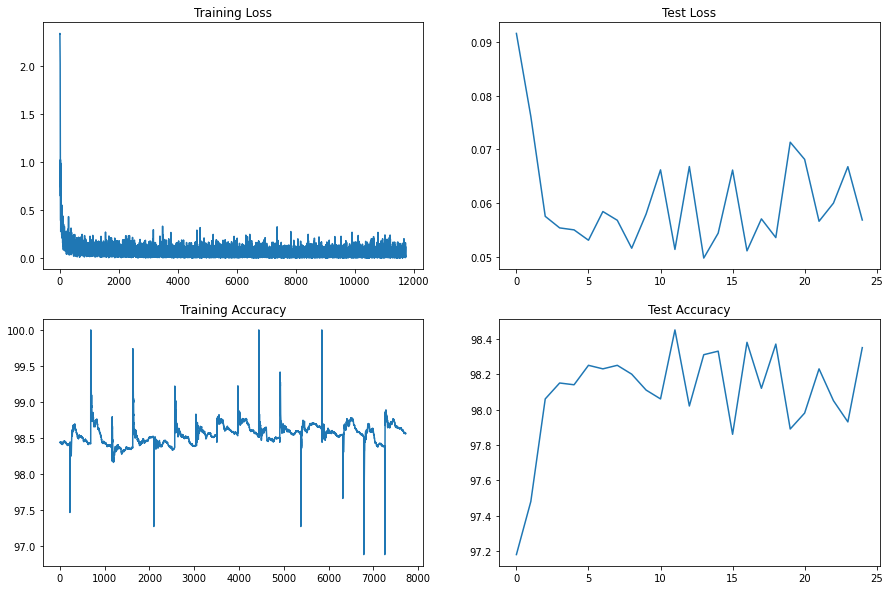

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [12]:
import numpy as np
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [13]:
correct = []
wrong = []
for i in range (20):
  images, labels = next (iter (test_loader))

  img = images
  # Turn off gradients to speed up this part
  with torch.no_grad():
      logps = model (img.cuda())

  # Output of the network are log-probabilities, need to take exponential for probabilities
  ps = torch.exp (logps)
  probabs = []
  for j, element in enumerate (ps):
      pred = torch.argmax(element)
      if pred == labels[j].item ():
          correct.append ([img[j], ps[j], pred, labels[j].item ()])
      else:
          wrong.append ([img[j], ps[j], pred, labels[j].item ()])

len (correct), len (wrong)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(2521, 39)

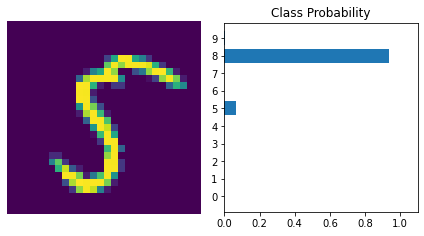

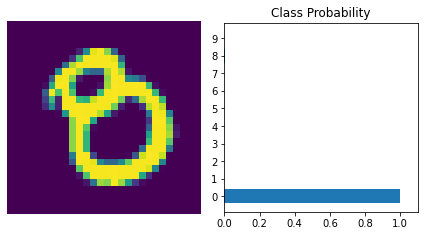

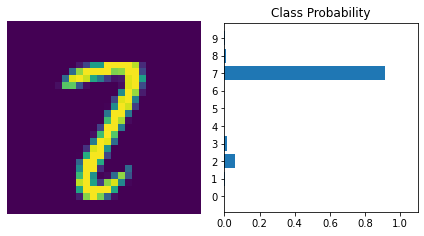

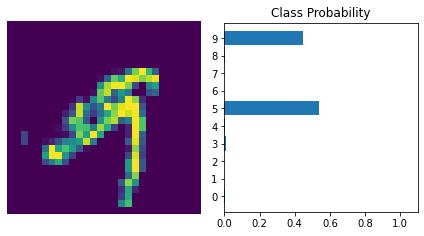

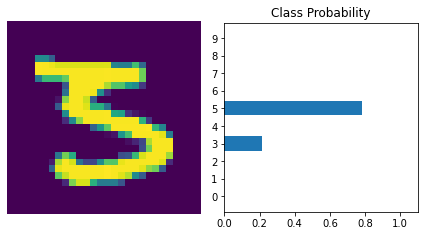

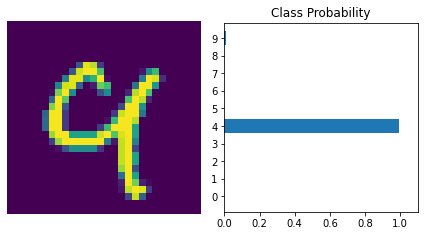

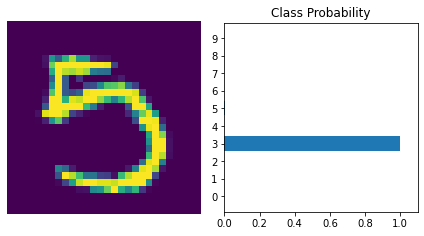

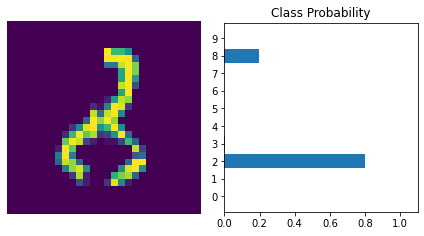

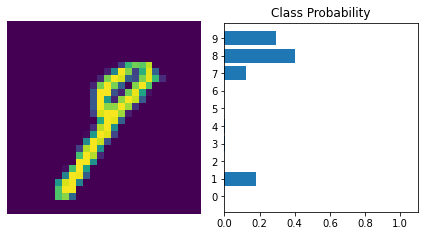

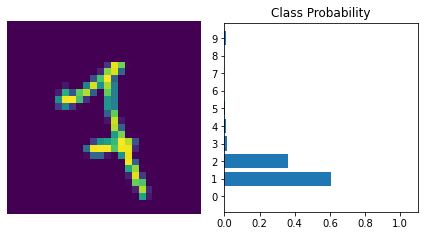

In [14]:
for i in range (10):
  view_classify (wrong[i][0], wrong[i][1])

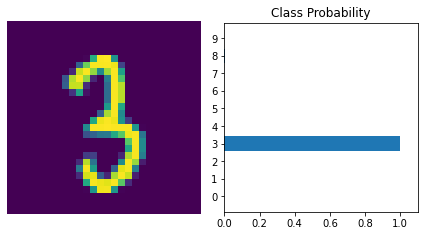

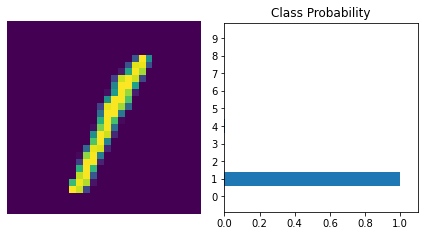

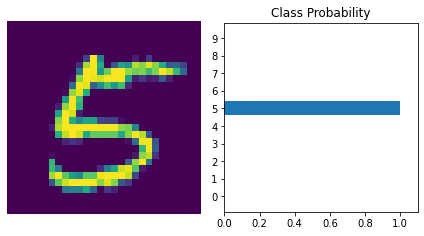

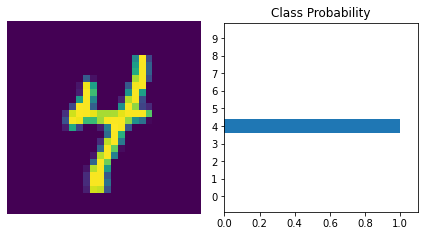

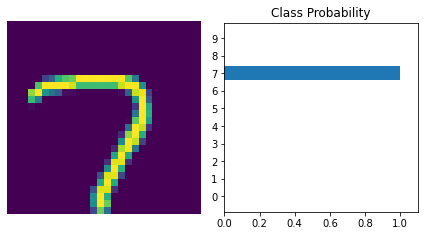

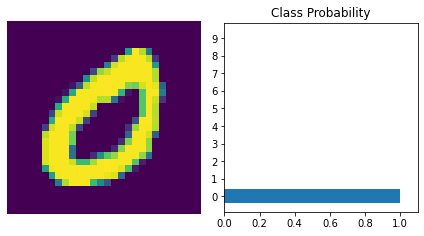

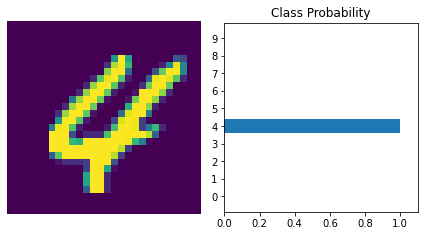

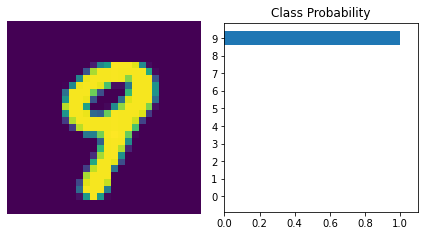

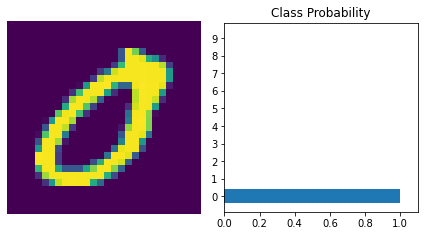

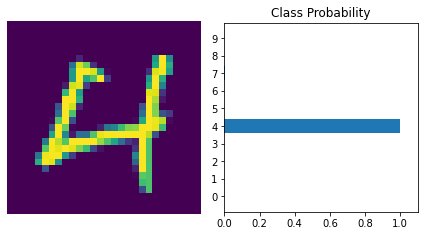

In [15]:
for i in range (10):
  view_classify (correct[i][0], correct[i][1])